<center><b>Deep Learning - Fine-Tuning Models</b></center><br>

The code below uses a pre-trained VGG16 convolutional neural network to categhorize the image data. In the first step the dense layers are removed  and new dense layers are created. Also, the convolutional layers are set to be frozen so they can not be modified. <br>
After training for several epochs, in the following step, some of the convolutional layers become unfrozen then being trained for further epochs. 

In [14]:
import os.path
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
print(tf.__version__)
import zipfile

2.1.0


In [15]:
# Handle dataset
FILE_PATH = os.getcwd()
CACHE_PATH = FILE_PATH+"/cached/deeplearning/"
data_file = FILE_PATH+"/data/DeepLearning/conv_net_data.zip"

data = zipfile.ZipFile(data_file)
data_file = data.open('data1.h5')

def loadDataH5():
    with h5py.File(data_file,'r') as hf:
      trainX = np.array(hf.get('trainX'))
      trainY = np.array(hf.get('trainY'))
      valX = np.array(hf.get('valX'))
      valY = np.array(hf.get('valY'))
      print (trainX.shape,trainY.shape)
      print (valX.shape,valY.shape)
      return trainX, trainY, valX, valY 
 
trainX, trainY, testX, testY = loadDataH5() 

(1020, 128, 128, 3) (1020,)
(340, 128, 128, 3) (340,)


In [16]:
IMG_DEPTH   = 3
IMG_WIDTH   = 128
IMG_HEIGHT  = 128
NUM_CLASSES = 17

NUM_EPOCHS  = 50

In [17]:
def plot_results(H, num_epochs):
  # plot the training loss and accuracy
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()
  pass

In [18]:
DENSE_LR = 0.001
CONV_LR  = 0.00001

In [19]:
def get_prediction_result(predicted_results, y_labels):
    # Calculate Loss
    y_labels_hot = np_utils.to_categorical(y_labels, NUM_CLASSES)
    predicted_results_clipped = tf.clip_by_value(predicted_results, 1e-10, 1.0)
    loss = (1.0/predicted_results_clipped.shape[0]) * tf.math.reduce_sum(-tf.math.multiply(tf.math.log(predicted_results_clipped),y_labels_hot))

    # Calculate Accuracy
    predicted_y = tf.math.argmax(predicted_results, 1)
    match_array = tf.equal(predicted_y, y_labels)
    accuracy = tf.reduce_sum(tf.cast(match_array, tf.float32)) / len(y_labels)

    return (loss, accuracy)


In [20]:
# Base class for implementing tuned CNN-s
class CNN_tuned_base:
  def __init__(self, try_to_load_weights=True, learning_rate=DENSE_LR):
    # Initialise Variables
    self.BATCH_SIZE = 16

    self.optimiser = tf.keras.optimizers.RMSprop(lr=learning_rate)
    # Initialise model
    # create_model returns the conv model and the combined model separately. This makes it easier to unfreeze layers
    self.conv_model, self.model = self.create_model(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, NUM_CLASSES)
    self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimiser, metrics=['accuracy'])

    # Saved data file names
    self.weights_file_name = "{}{}_2.hdf5".format(CACHE_PATH, self.get_name())
    self.val_accuracy_file_name = "{}{}_2_val_accuracy.txt".format(CACHE_PATH, self.get_name())

    # The current best val_loss
    self.best_val_accuracy = 0.0

    # If possible load the previous training results. Weights and assosiated val_loss
    if try_to_load_weights and os.path.isfile(self.weights_file_name):
      self.load_best_weights()

  def load_best_val_accuracy_value(self):
    """
    This function is used to load the validation accuracy of the best model.
    It is stored in a txt file when the best model's weights were cached
    """
    if os.path.isfile(self.val_accuracy_file_name):
      loss_file = open(self.val_accuracy_file_name, "r")
      self.best_val_accuracy = float(loss_file.read())
      loss_file.close()
      print("{} - Loaded best val_accuracy value: {:.4f} from: {}".format(self.get_name(), self.best_val_accuracy, self.val_accuracy_file_name))


  def save_weights_callback(self, logs):
    """
    This is a custom callback function to be used to cache the weights of the network when val_accuracy increases
    """
    val_loss = logs.get('val_accuracy')
    if val_loss > self.best_val_accuracy:
      print("\n{} - Caching Checkpoint - val_accuracy has improved from: {:.4f} to: {:.4f}".format(self.get_name(), self.best_val_accuracy, val_loss))
      self.best_val_accuracy = val_loss
      
      self.model.save_weights(self.weights_file_name)

      loss_file = open(self.val_accuracy_file_name,"w")
      loss_file.write(str(val_loss))
      loss_file.close()
    else:
      print("\n{} Val_accuracy did not improve. Best is: {:.4f}. Not Caching".format(self.get_name(), self.best_val_accuracy))

  def train(self, tr_x, tr_y, val_x, val_y, num_epochs=NUM_EPOCHS):
    print("{} - Training for {} epochs".format(self.get_name(), num_epochs))

    # Create the image generator for Data Augmentation
    datagen_batch = len(tr_x) / self.BATCH_SIZE
    datagen = self.create_image_generator()

    # Create the model checkpointer
    custom_checkpointing_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs:self.save_weights_callback(logs))

    # Train and return history
    return self.model.fit(datagen.flow(tr_x, tr_y, batch_size=self.BATCH_SIZE), steps_per_epoch=datagen_batch, epochs=num_epochs, validation_data=(val_x, val_y), callbacks=[custom_checkpointing_callback])

  def unfreeze_top_x_layers(self, num_layers_to_unfreeze):
    """
    This function is used to unfreeze a set number of layers of the convolutional model
    """
    num_layers = len(self.conv_model.layers)
    keep_untrainable = num_layers - num_layers_to_unfreeze
    if keep_untrainable < 0:
      print("{} ERROR: Cannot unfreeze more layers than how many exists. Num layers: {}".format(self.get_name(), num_layers))
    print("{} contains {} conv layers. Unfreezing {} conv layers".format(self.get_name(), num_layers, (num_layers - keep_untrainable)))

    num_trainables_before = len(self.model.trainable_variables)

    self.conv_model.trainable = True
    for layer in self.conv_model.layers[:keep_untrainable]:
      layer.trainable = False

    print("{} Num trainable variables before: {} after: {}".format(self.get_name(), num_trainables_before, len(self.model.trainable_variables)))

  def load_best_weights(self):
    """
    Loads the best weights cached
    """
    print("{} - Loading previous training data".format(self.get_name()))
    self.model.load_weights(self.weights_file_name)
    print("{} - Loaded previous model weights from: {}".format(self.get_name(), self.weights_file_name))
    self.load_best_val_accuracy_value()

  def predict(self, val_x):
    """
    Runs prediction using the model
    """
    return self.model.predict(val_x)

  def create_model(self, width, height, depth, classes):
    """
    Must be implemented in derived class
    This function created the model's architecture using pre trained conv nets
    and added dense layers
    """
    raise NotImplementedError()

  def create_image_generator(self):
    """
    Must be implemented in derived class
    This function creates the image generator for data augmentation 
    """
    raise NotImplementedError()

  def get_name(self):
    """
    Must be implemented in derived class
    Returns a string name for the class. Used by save files for file names
    """
    raise NotImplementedError()


In [21]:
class VGG_16_NET(CNN_tuned_base):
  def get_name(self):
    return "VGG_16"

  def create_model(self, width, height, depth, classes):
    # Create the pre-trained convolutional model
    conv_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(width, height, depth))
    conv_model.trainable = False

    model = tf.keras.models.Sequential()
    model.add(conv_model) 
    # add dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(classes, activation='softmax'))

    # return the conv model and the combined model spearately.
    return (conv_model, model)

  def create_image_generator(self):
    return tf.keras.preprocessing.image.ImageDataGenerator(
       rotation_range=45,
       width_shift_range=0.3,
       height_shift_range=0.3,
       horizontal_flip=True,
       vertical_flip=False)
    pass

VGG 16

In [9]:
# Create the instance of the class, by default this will load in checkpointed weigths
load_weigths = False # Set load_weigths to false to start the training again
my_net = VGG_16_NET(load_weigths)

VGG_16 - Training for 10 epochs
  ...
    to  
  ['...']
Train for 63.75 steps, validate on 340 samples
Epoch 1/10
63/63 [============================>.] - ETA: 1s - loss: 4.8346 - accuracy: 0.1733
VGG_16 - Caching Checkpoint - val_accuracy has improved from: 0.0000 to: 0.5088
64/63 [==============================] - 149s 2s/step - loss: 4.7921 - accuracy: 0.1745 - val_loss: 1.5725 - val_accuracy: 0.5088
Epoch 2/10
63/63 [============================>.] - ETA: 1s - loss: 1.8973 - accuracy: 0.3655
VGG_16 - Caching Checkpoint - val_accuracy has improved from: 0.5088 to: 0.5765
64/63 [==============================] - 129s 2s/step - loss: 1.8936 - accuracy: 0.3667 - val_loss: 1.2048 - val_accuracy: 0.5765
Epoch 3/10
63/63 [============================>.] - ETA: 1s - loss: 1.4806 - accuracy: 0.5110
VGG_16 - Caching Checkpoint - val_accuracy has improved from: 0.5765 to: 0.7176
64/63 [==============================] - 133s 2s/step - loss: 1.4770 - accuracy: 0.5118 - val_loss: 0.8677 - val_a

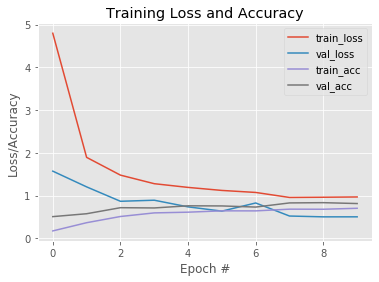

In [10]:
# Conv Layers are locked, train dense layers
# Run this cell multiple times and/or increase num_epochs until best result is achieved. Best weigths will be saved!
num_epochs = 10
history = my_net.train(trainX, trainY, testX, testY, num_epochs)
plot_results(history, num_epochs)


In [11]:
# Finished training dense layers. Prep for training conv layers:
# Reload best weights, change learning rate, unfreeze layers
# recreate model with a new learning rate. This also loads best weights
my_net = VGG_16_NET(True, CONV_LR)
my_net.unfreeze_top_x_layers(4)

pred_y = my_net.predict(testX)
pred_loss, pred_accuracy = get_prediction_result(pred_y, testY)
print("{} Best Model prediction loss: {:.4f}, accuracy: {:.2f}%".format(my_net.get_name(), pred_loss, pred_accuracy*100.0))

VGG_16 - Loading previous training data
VGG_16 - Loaded previous model weights from: C:\Users\danie\Documents\Work\AI_portfolio\AI_portfolioVGG_16_2.hdf5
VGG_16 - Loaded best val_accuracy value: 0.8353 from: C:\Users\danie\Documents\Work\AI_portfolio\AI_portfolioVGG_16_2_val_accuracy.txt
VGG_16 contains 19 conv layers. Unfreezing 4 conv layers
VGG_16 Num trainable variables before: 6 after: 12
VGG_16 Best Model prediction loss: 0.5036, accuracy: 83.53%


VGG_16 - Training for 10 epochs
  ...
    to  
  ['...']
Train for 63.75 steps, validate on 340 samples
Epoch 1/10
63/63 [============================>.] - ETA: 1s - loss: 0.7254 - accuracy: 0.7629
VGG_16 - Caching Checkpoint - val_accuracy has improved from: 0.8353 to: 0.8441
64/63 [==============================] - 136s 2s/step - loss: 0.7290 - accuracy: 0.7608 - val_loss: 0.4541 - val_accuracy: 0.8441
Epoch 2/10
63/63 [============================>.] - ETA: 1s - loss: 0.6570 - accuracy: 0.8008
VGG_16 - Caching Checkpoint - val_accuracy has improved from: 0.8441 to: 0.8559
64/63 [==============================] - 137s 2s/step - loss: 0.6532 - accuracy: 0.8029 - val_loss: 0.4285 - val_accuracy: 0.8559
Epoch 3/10
63/63 [============================>.] - ETA: 1s - loss: 0.6709 - accuracy: 0.7819
VGG_16 - Caching Checkpoint - val_accuracy has improved from: 0.8559 to: 0.8647
64/63 [==============================] - 134s 2s/step - loss: 0.6660 - accuracy: 0.7833 - val_loss: 0.4157 - val_a

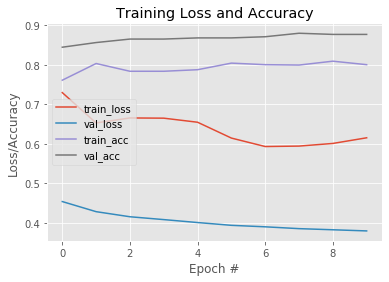

In [12]:
# Train dense and conv layers
# Run this cell multiple times and/or increase num_epochs until best result is achieved. Best weigths will be saved!
num_epochs = 10
history = my_net.train(trainX, trainY, testX, testY, num_epochs)
plot_results(history, num_epochs)